In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
res_2_df = pd.read_csv('results_1.2.csv')

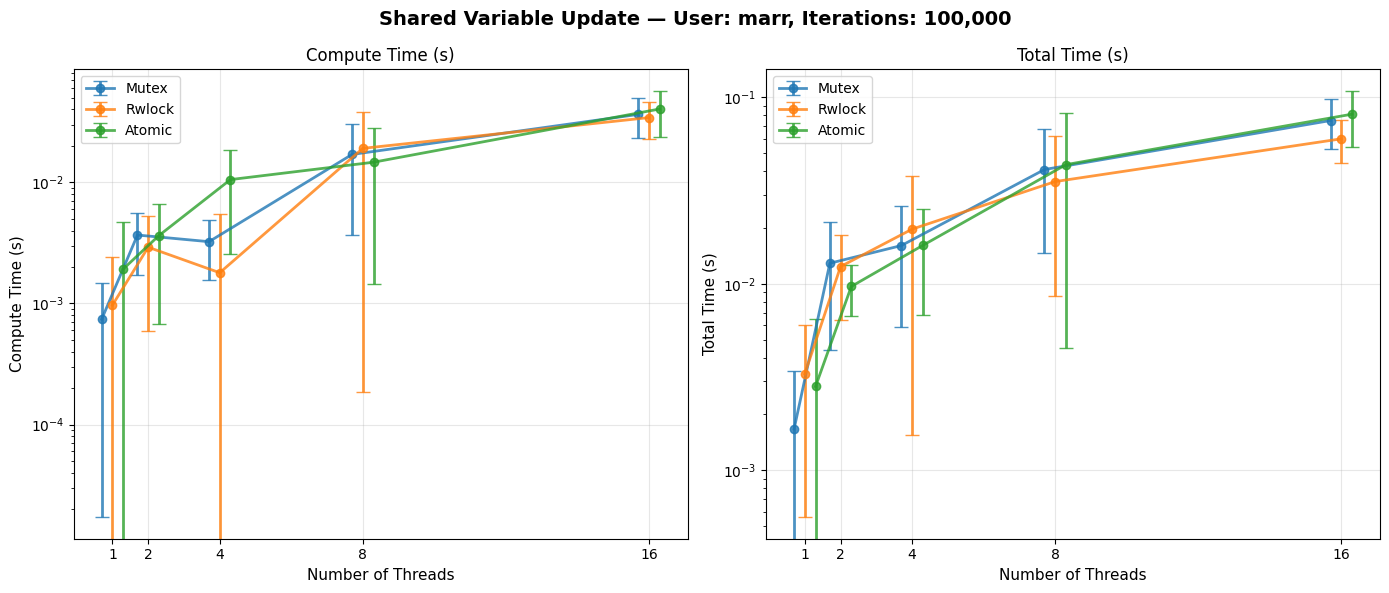

Saved: plots/plot_1_2_marr_iter100K.png


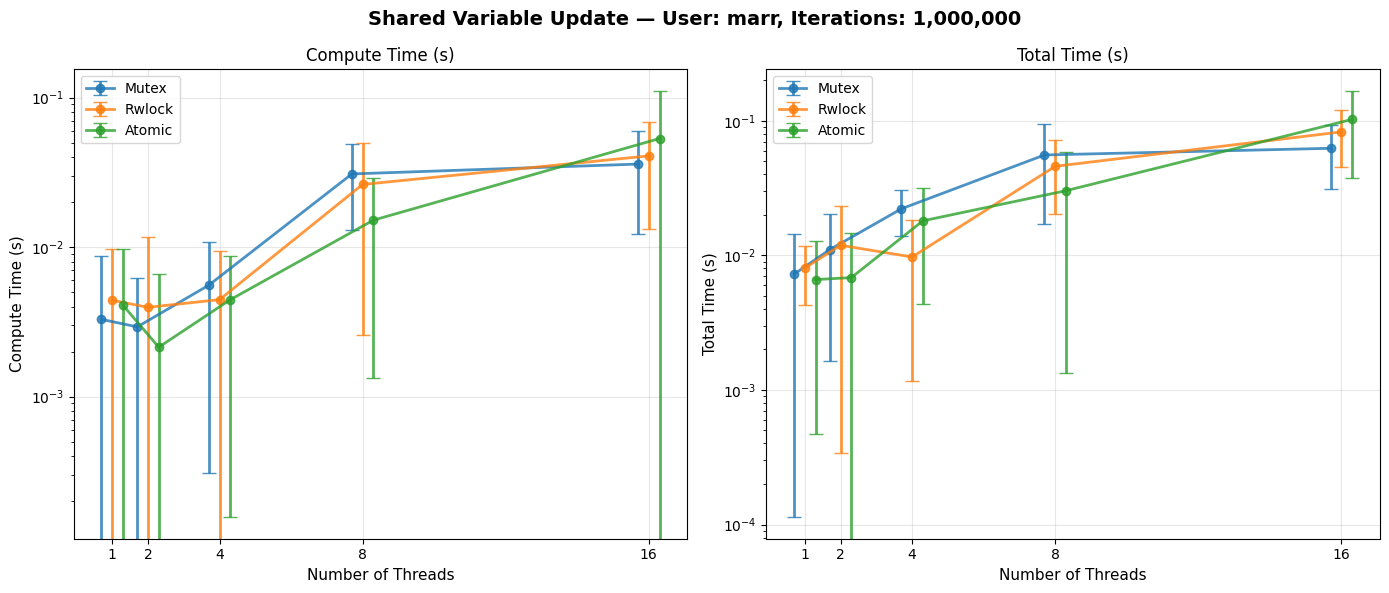

Saved: plots/plot_1_2_marr_iter1M.png

Unique users: ['marr']
Unique iterations: [np.int64(100000), np.int64(1000000)]
All plots generated with error bars and means.


In [31]:
os.makedirs("plots", exist_ok=True)

# Normalize dataframe
df = res_2_df.copy()
df['user'] = df.get('user', 'unknown')
df['method'] = df['method'].astype(str).str.strip().str.lower()
df['threads'] = pd.to_numeric(df.get('threads'), errors='coerce')
df.loc[df['method'] == 'sequential', 'threads'] = 0
df['threads'] = df['threads'].fillna(1).astype(int)
df['iterations'] = pd.to_numeric(df.get('iterations'), errors='coerce').fillna(0).astype(int)

# Remove sequential (threads=0) entries from non-sequential methods
df = df[~((df['threads'] == 0) & (df['method'] != 'sequential'))]
# Remove sequential entries
df = df[df['method'] != 'sequential']

time_cols = ["time_compute", "time_total"]
for col in time_cols:
    df[col] = pd.to_numeric(df.get(col), errors='coerce').fillna(0)

# Get unique users and iterations
unique_users = sorted(df["user"].unique())
unique_iterations = sorted(df["iterations"].unique())
methods_order = ["mutex", "rwlock", "atomic"]
colors = {"mutex": "#1f77b4", "rwlock": "#ff7f0e", "atomic": "#2ca02c", "sequential": "#7f7f7f"}

# Create plots for each user
for user in unique_users:
    user_df = df[df["user"] == user].copy()
    
    if user_df.empty:
        continue
    
    # Plot for each iteration
    for iteration in unique_iterations:
        iter_df = user_df[user_df["iterations"] == iteration].copy()
        
        if iter_df.empty:
            continue
        
        # Aggregate by method and threads
        stats = iter_df.groupby(["method", "threads"])[time_cols].agg(["mean", "std"]).reset_index()
        stats.columns = ["_".join(c).strip("_") for c in stats.columns]
        
        # Filter to valid methods
        stats = stats[stats["method"].isin(methods_order)]
        stats["method"] = pd.Categorical(stats["method"], categories=methods_order, ordered=True)
        stats = stats.sort_values("method")
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle(f"Shared Variable Update — User: {user}, Iterations: {iteration:,}", 
                     fontsize=14, fontweight="bold")
        
        # Define jitter offset for each method (increased jitter)
        unique_methods = sorted(stats["method"].unique(), key=lambda m: methods_order.index(m))
        jitter_offset = np.linspace(-0.3, 0.3, len(unique_methods))
        
        for col_idx, (col, ylabel) in enumerate(zip(["time_compute", "time_total"], 
                                                      ["Compute Time (s)", "Total Time (s)"])):
            ax = axes[col_idx]
            
            for method_idx, method in enumerate(unique_methods):
                method_stats = stats[stats["method"] == method].copy()
                
                if method_stats.empty:
                    continue
                
                x_jitter = method_stats["threads"] + jitter_offset[method_idx]
                y_mean = method_stats[f"{col}_mean"]
                y_std = method_stats[f"{col}_std"]
                
                ax.errorbar(x_jitter, y_mean, yerr=y_std, marker='o', 
                           label=method.capitalize(), linewidth=2, capsize=5, 
                           linestyle='-', alpha=0.8, color=colors.get(method, "#444"))
            
            ax.set_xlabel("Number of Threads", fontsize=11)
            ax.set_ylabel(ylabel, fontsize=11)
            ax.set_title(ylabel, fontsize=12)
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.set_xticks(sorted(stats["threads"].unique()))
            ax.set_yscale("log")
        
        plt.tight_layout()
        iter_label = f"{iteration//1_000_000}M" if iteration >= 1_000_000 else f"{iteration//1000}K"
        outpath = f"plots/plot_1_2_{user}_iter{iter_label}.png"
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
        plt.show(fig)
        print(f"Saved: {outpath}")

# Create combined plot with all users
if len(unique_users) > 1:
    for iteration in unique_iterations:
        iter_df = df[df["iterations"] == iteration].copy()
        
        if iter_df.empty:
            continue
        
        # Aggregate across all users
        stats_all = iter_df.groupby(["method", "threads"])[time_cols].agg(["mean", "std"]).reset_index()
        stats_all.columns = ["_".join(c).strip("_") for c in stats_all.columns]
        
        stats_all = stats_all[stats_all["method"].isin(methods_order)]
        stats_all["method"] = pd.Categorical(stats_all["method"], categories=methods_order, ordered=True)
        stats_all = stats_all.sort_values("method")
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle(f"Shared Variable Update — All Users, Iterations: {iteration:,}", 
                     fontsize=14, fontweight="bold")
        
        unique_methods = sorted(stats_all["method"].unique(), key=lambda m: methods_order.index(m))
        jitter_offset = np.linspace(-0.3, 0.3, len(unique_methods))
        
        for col_idx, (col, ylabel) in enumerate(zip(["time_compute", "time_total"], 
                                                      ["Compute Time (s)", "Total Time (s)"])):
            ax = axes[col_idx]
            
            for method_idx, method in enumerate(unique_methods):
                method_stats = stats_all[stats_all["method"] == method].copy()
                
                if method_stats.empty:
                    continue
                
                x_jitter = method_stats["threads"] + jitter_offset[method_idx]
                y_mean = method_stats[f"{col}_mean"]
                y_std = method_stats[f"{col}_std"]
                
                ax.errorbar(x_jitter, y_mean, yerr=y_std, marker='o', 
                           label=method.capitalize(), linewidth=2, capsize=5, 
                           linestyle='-', alpha=0.8, color=colors.get(method, "#444"))
            
            ax.set_xlabel("Number of Threads", fontsize=11)
            ax.set_ylabel(ylabel, fontsize=11)
            ax.set_title(ylabel, fontsize=12)
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.set_xticks(sorted(stats_all["threads"].unique()))
            ax.set_yscale("log")
        
        plt.tight_layout()
        iter_label = f"{iteration//1_000_000}M" if iteration >= 1_000_000 else f"{iteration//1000}K"
        outpath = f"plots/plot_1_2_all_users_iter{iter_label}.png"
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
        plt.show(fig)
        print(f"Saved: {outpath}")

print(f"\nUnique users: {list(unique_users)}")
print(f"Unique iterations: {unique_iterations}")
print("All plots generated with error bars and means.")